<a href="https://colab.research.google.com/github/brialorelle/headcam-objects/blob/master/ImageAnalyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of this file

Dictionary structures included in this notebook:

idMapper[AssignmentId]
 *   'HITId': HITId
 *   'WorkerId': WorkerId

bboxes[AssignmentId]
*   list of bounding box objects with fields:
  *  height
  *  label
  * xmin (start pixel of bbox on left side)
  * ymin (start pixel of bbox on top)
  * width
  * HITId

answers[AssignmentId]
  * ['boundingBoxes'] : list of dictionaries containing:
    *  'height' : height
    *  'label': label
    * 'left': (start pixel of bbox on left side)
    * 'top': (start pixel of bbox on top)
    * 'width': width
  * ['numBoxes'] : number of bounding boxes
  * ['HITId'] : HITId

images[HITId]
* image objects with fields:
  * height
  * width
  * url
  * numWorkers

categories[categoryId]
* category/label name

answersReview[AssignmentId]
  * ['WorkerId'] : store WorkerId to easily grab bad actors
  * ['goodLabels'] : number of good labels
  * ['goodBoxes'] : number of good boxes

After removing bad actors:
object_inst[category/label name]
* number of instances of each category/label name












In [1]:
import boto3
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from io import BytesIO
from PIL import Image
import pandas as pd

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Object Label List

Use the function from the txt2list.py file (copying it for ease of use)

In [3]:
def loadObjList(txtFile):
    # define an empty list
    words = []

    # open file and read the content into a list
    with open(txtFile, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            currentWord = line[:-1]

            # add item to the list
            words.append(currentWord)

    words = list(set(words))
    words.sort() #alphabetize
    words.insert(0, 'other / label not found')
    return words

Make the category dictionary with IDs.

In [4]:
categories = {}       # dictionary mapping labels to ids
catId = 1
labels = loadObjList('/content/drive/My Drive/CSLI/object_list.txt')
for cat in labels:
  categories[cat] = catId
  catId+=1

So now, we have a list of labels from the object list and a mapping of category names to ids (this is for putting the data in COCO JSON format)

In [5]:
print(labels)
categories

['other / label not found', 'activity gym', 'airplane', 'alligator', 'animal', 'ant', 'apple', 'applesauce', 'art', 'backpack', 'backyard', 'bag', 'ball', 'balloon', 'banana', 'baseball glove', 'basket', 'bat', 'bath toy', 'bathtub', 'beanbag', 'beans', 'bear', 'bed', 'bee', 'bench', 'bicycle', 'bike stand', 'bird', 'blanket', 'blender', 'block', 'blocks', 'boat', 'book', 'boots', 'bottle', 'bouncer', 'bowl', 'box', 'bread', 'broccoli', 'broom', 'brush', 'bubbles', 'bucket', 'bug', 'bunny', 'bus', 'bush', 'butter', 'butterfly', 'button', 'cabinet', 'cake', 'camera', 'can (object)', 'candy', 'car', 'carrots', 'cat', 'cell phone', 'cereal', 'chair', 'chalk', 'changing table', 'cheerios', 'cheese', 'chicken (animal)', 'chicken (food)', 'chocolate', 'clock', 'closet', 'cloud', 'coffee', 'coin', 'coins', 'coke', 'comb', 'container', 'cookie', 'corn', 'cow', 'cracker', 'cradle', 'crayon', 'crayons', 'crib', 'cup', 'curtain', 'deer', 'desk', 'desktop', 'diaper', 'dining table', 'dish', 'dog',

# Load Response CSVs

Grab and load CSV results from batches, the paths listed below include all the collected batches from MTurk. The toy batches include results from lab members and the pilot batches include results from the 150 random images.

In [137]:
toyBatch = '/content/drive/My Drive/CSLI/Batch Results/Batch_286363_batch_results.csv'
preToyBatch = '/content/drive/My Drive/CSLI/Batch Results/Batch_287989_batch_results.csv'
pilotBatch1= '/content/drive/My Drive/CSLI/Batch Results/Batch_4140330_batch_results.csv'
pilotBatch2= '/content/drive/My Drive/CSLI/Batch Results/Batch_4140307_batch_results.csv'
pilotBatch= '/content/drive/My Drive/CSLI/Batch Results/Batch_4148388_batch_results.csv'
result1 = pd.read_csv(pilotBatch1)
result2 = pd.read_csv(pilotBatch2)
result = pd.read_csv(pilotBatch)

In [138]:
results = pd.concat([result, result1, result2], ignore_index=True)
results = results.rename(columns={'Input.image_url':'image_url', 'Answer.taskAnswers':'taskAnswers'})
results

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,AutoApprovalDelayInSeconds,Expiration,NumberOfSimilarHITs,LifetimeInSeconds,AssignmentId,WorkerId,AssignmentStatus,AcceptTime,SubmitTime,AutoApprovalTime,ApprovalTime,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,image_url,taskAnswers,Approve,Reject
0,36FQTHX3Z3RAKFE0K2HIXM7S50IB3M,30E4L8P2E1IGB4SPQBIV9J8TS47B8P,Identify the objects in an image,Annotate up to 5 objects in a single image by ...,"object detection, object classification",$0.30,Tue Aug 11 09:12:57 PDT 2020,2,BatchId:4148388;OriginalHitTemplateId:928390828;,7200,10800,Tue Aug 18 12:13:07 PDT 2020,NaN,NaN,30MVJZJNHMD54KZMF50BB7PH7U89J4,A29TP4KM7E80WJ,Approved,Tue Aug 11 09:13:27 PDT 2020,Tue Aug 11 09:16:28 PDT 2020,Tue Aug 11 12:16:28 PDT 2020,Tue Aug 11 12:17:12 PDT 2020,NaN,NaN,181,100% (2/2),100% (2/2),100% (2/2),http://langcog.stanford.edu/expts/saycam/frame...,"[{""annotatedResult"":{""boundingBoxes"":[{""height...",NaN,NaN
1,36FQTHX3Z3RAKFE0K2HIXM7S50IB3M,30E4L8P2E1IGB4SPQBIV9J8TS47B8P,Identify the objects in an image,Annotate up to 5 objects in a single image by ...,"object detection, object classification",$0.30,Tue Aug 11 09:12:57 PDT 2020,2,BatchId:4148388;OriginalHitTemplateId:928390828;,7200,10800,Tue Aug 18 12:13:07 PDT 2020,NaN,NaN,3OLQQLKKNSPMZGQ3NGGX3LQSYROJEO,A2FIMX1INRS3OG,Approved,Tue Aug 11 13:27:36 PDT 2020,Tue Aug 11 13:29:11 PDT 2020,Tue Aug 11 16:29:11 PDT 2020,Tue Aug 11 16:29:12 PDT 2020,NaN,NaN,95,100% (6/6),100% (6/6),100% (6/6),http://langcog.stanford.edu/expts/saycam/frame...,"[{""annotatedResult"":{""boundingBoxes"":[{""height...",NaN,NaN
2,3B623HUYJ4QV2Y1875Y9ESP3PAW8SC,30E4L8P2E1IGB4SPQBIV9J8TS47B8P,Identify the objects in an image,Annotate up to 5 objects in a single image by ...,"object detection, object classification",$0.30,Tue Aug 11 09:12:57 PDT 2020,2,BatchId:4148388;OriginalHitTemplateId:928390828;,7200,10800,Tue Aug 18 09:12:57 PDT 2020,NaN,NaN,35GCEFQ6I5O9PXFAGI2N8OALQ0B3Z2,AU5R5BJ1D6MEX,Approved,Tue Aug 11 09:40:18 PDT 2020,Tue Aug 11 09:43:00 PDT 2020,Tue Aug 11 12:43:00 PDT 2020,Tue Aug 11 12:43:13 PDT 2020,NaN,NaN,162,100% (3/3),100% (3/3),100% (3/3),http://langcog.stanford.edu/expts/saycam/frame...,"[{""annotatedResult"":{""boundingBoxes"":[],""input...",NaN,NaN
3,3B623HUYJ4QV2Y1875Y9ESP3PAW8SC,30E4L8P2E1IGB4SPQBIV9J8TS47B8P,Identify the objects in an image,Annotate up to 5 objects in a single image by ...,"object detection, object classification",$0.30,Tue Aug 11 09:12:57 PDT 2020,2,BatchId:4148388;OriginalHitTemplateId:928390828;,7200,10800,Tue Aug 18 09:12:57 PDT 2020,NaN,NaN,35GMH2SV3EH00RH03T82BH7EXLYOEC,A1V2H0UF94ATWY,Approved,Tue Aug 11 09:13:11 PDT 2020,Tue Aug 11 09:26:21 PDT 2020,Tue Aug 11 12:26:21 PDT 2020,Tue Aug 11 12:27:12 PDT 2020,NaN,NaN,790,100% (10/10),100% (1/1),100% (1/1),http://langcog.stanford.edu/expts/saycam/frame...,"[{""annotatedResult"":{""boundingBoxes"":[{""height...",NaN,NaN
4,30P8I9JKOILS78ZA32WBDVZJMOP5VC,30E4L8P2E1IGB4SPQBIV9J8TS47B8P,Identify the objects in an image,Annotate up to 5 objects in a single image by ...,"object detection, object classification",$0.30,Tue Aug 11 09:12:57 PDT 2020,2,BatchId:4148388;OriginalHitTemplateId:928390828;,7200,10800,Tue Aug 18 09:12:57 PDT 2020,NaN,NaN,35BLDD71I6XT16HT0S8TRJ24HKAZV1,AE1OI33BMMWUS,Approved,Tue Aug 11 09:58:29 PDT 2020,Tue Aug 11 10:06:47 PDT 2020,Tue Aug 11 13:06:47 PDT 2020,Tue Aug 11 13:07:13 PDT 2020,NaN,NaN,498,100% (1/1),100% (1/1),100% (1/1),http://langcog.stanford.edu/expts/saycam/frame...,"[{""annotatedResult"":{""boundingBoxes"":[{""height...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,338431Z1FLFMMBOBZXN0L4A7IBYORK,32KI9HN0SH9DW3HARHQBZZD93J11U5,Draw bounding boxes around objects in an image,Help annotate the objects that are in the i

In [139]:
results.nunique()

HITId                          176
HITTypeId                        3
Title                            2
Description                      2
Keywords                         1
Reward                           1
CreationTime                    13
MaxAssignments                   2
RequesterAnnotation              3
AssignmentDurationInSeconds      1
AutoApprovalDelayInSeconds       1
Expiration                      15
NumberOfSimilarHITs              0
LifetimeInSeconds                0
AssignmentId                   326
WorkerId                       173
AssignmentStatus                 2
AcceptTime                     267
SubmitTime                     324
AutoApprovalTime               324
ApprovalTime                   199
RejectionTime                    0
RequesterFeedback                0
WorkTimeInSeconds              297
LifetimeApprovalRate            18
Last30DaysApprovalRate          13
Last7DaysApprovalRate           13
image_url                      150
taskAnswers         

Important observation from above values: we have 150 image urls and 176 HITIds -- we have repeat HITIds so we cannot use those as keys for the image url dictionary!

In [167]:
import os
def get_filename_as_int(filename):
    try:
        filename = os.path.basename(filename)
        filename = filename.split('/')[-1].split('.')[0].split('-')[0]
        return filename
    except:
        raise ValueError("Filename %s is supposed to be an integer." % (filename))

In [168]:
images = []
for url in results.image_url.unique():
  imKey = get_filename_as_int(url)
  images.append(imKey)

In [170]:
imKey

'9871'

In [171]:
url

'http://langcog.stanford.edu/expts/saycam/frames/9871-A_20141004_2421_01.mp4-48450.jpg'

Create a boundingBox object with height, width, xmin, and ymin attributes and an image object with filename, HITId, height, and width attributes; we'll store our annotations in these objects for easy access during analyses

In [ ]:
"""
class boundingBox(object):
  def __init__(self, height, width, left, top, label, HITId):
    self.height = height
    self.width = width
    self.xmin = left
    self.ymin = top
    self.label = label
  """

In [197]:
class boundingBox(object):
  def __init__(self, bboxDict, HITId, imKey):
    self.height = bboxDict['height']
    self.width = bboxDict['width']
    self.xmin = bboxDict['left']
    self.ymin = bboxDict['top']
    self.label = bboxDict['label']
    self.HITId = HITId
    self.imKey = imKey


class image(object):
  def __init__(self, height, width, url):
    self.height = height
    self.width = width
    self.url = url
    self.numWorkers = 0

We organize the annotated results using a nested dictionary with workerIds and HITIds and first and second keys. 
To have a unique ID for each annotation, we map assignment Ids to workerId and HITId pairs.

In [198]:
idMapper = {}                   # initialize an empty dictionary where we'll map assignmentIds to worker and HIT ids
answers = {}                    # initialize an empty dictionary where we'll put the annotations as values
images = {}
answersReview = {}
workerAnswers = {}

for row in results.itertuples():
  url = row.image_url
  HITId = row.HITId
  answer = json.loads(row.taskAnswers)[0]
  bbox = answer['annotatedResult']['boundingBoxes']
  imKey = get_filename_as_int(url)
  if imKey not in images.keys():
    imProp = answer['annotatedResult']['inputImageProperties']
    im = image(imProp['height'],imProp['width'], url)
    images[imKey] = {'image': im, 'HITIds': [HITId]}
  else:
    images[imKey]['HITIds'].append(HITId)
  images[imKey]['image'].numWorkers = images[imKey]['image'].numWorkers + 1
  idMapper[row.AssignmentId] = {'HITId': HITId, 'WorkerId': row.WorkerId, 'ImageKey' : imKey}
  answers[row.AssignmentId] = {'boundingBoxes': bbox, 'numBoxes': len(bbox),'ImageKey': imKey}
  answersReview[row.AssignmentId] = {'WorkerId': row.WorkerId, 'numBoxes': len(bbox)}

In [199]:
bboxes = {}
for key in answers:
  bboxes[key] = []
  for instance in answers[key]['boundingBoxes']:
    bboxes[key].append(boundingBox(instance, idMapper[key]['HITId'], idMapper[key]['ImageKey']))

Review answers and update answersReview.

* Count good labels and then count good bounding boxes (perhaps based on good labels)



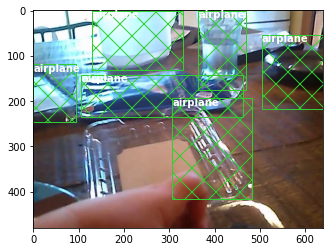

KeyboardInterrupt: ignored

In [201]:
# count good labels
for id in answers:
  if answers[id]['numBoxes'] != 0:
    response = requests.get(images[idMapper[id]['ImageKey']]['image'].url)
    img = Image.open(BytesIO(response.content))
    im = np.array(img, dtype=np.uint8)
    # Create figure, axes, and display the image
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    # Draw the bounding boxes
    for answer in answers[id]['boundingBoxes']:
      rect = patches.Rectangle((answer['left'],answer['top']),
                              answer['width'],answer['height'],
                              linewidth=1,edgecolor='#32cd32',facecolor='none', 
                              hatch='x', label=answer['label'])
      ax.add_patch(rect)
      ax.annotate(answer['label'], (answer['left'],answer['top']+15),
                  color='w', weight='bold')
    # Show the bounding box
    plt.show()
    goodLabels = input('How many of the ' + str(answers[id]['numBoxes']) + ' labels are good? \n')
    answersReview[id]['goodLabels']= int(goodLabels)

In [ ]:
# count good bounding boxes
for id in answers:
  if answers[id]['numBoxes'] != 0:
    response = requests.get(images[idMapper[id]['ImageKey']]['image'].url)
    img = Image.open(BytesIO(response.content))
    im = np.array(img, dtype=np.uint8)
    # Create figure, axes, and display the image
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    # Draw the bounding boxes
    for answer in answers[id]['boundingBoxes']:
      rect = patches.Rectangle((answer['left'],answer['top']),
                              answer['width'],answer['height'],
                              linewidth=1,edgecolor='#32cd32',facecolor='none', 
                              hatch='x', label=answer['label'])
      ax.add_patch(rect)
      ax.annotate(answer['label'], (answer['left'],answer['top']+15),
                  color='w', weight='bold')
    # Show the bounding box
    plt.show()
    goodBoxes = input('How many of the ' + str(answers[id]['numBoxes']) + ' bounding boxes are good? \n')
    answersReview[id]['goodBoxes'] = int(goodBoxes)

In [76]:
workerAnswers = {}
for id in answers:
  workerId = idMapper[id]['WorkerId']
  if workerId not in workerAnswers.keys():
    workerAnswers[workerId] = {'AssignmentIds': [id], 'numHITs': 1, 'correctRate' : answers[id]['numCorrect']/answers[id]['numBoxes']}
  else:
    currentWorker = workerAnswers[workerId]
    currentWorker['AssignmentIds'].append(id)
    currentWorker['numHITs'] += 1
    currentWorker['correctRate'] = np.mean([currentWorker['correctRate'],answers[id]['numCorrect']/answers[id]['numBoxes']])

In [77]:
workerAnswers

{'A12PUQIBXRBOXV': {'AssignmentIds': ['3NPFYT4IZC4LEERJAFLMUXJJMETGXJ'],
  'correctRate': 1.0,
  'numHITs': 1},
 'A173A97OFDAX9F': {'AssignmentIds': ['3OSWBBLG1EXI2UHS8PKEOCGM9KADXZ'],
  'correctRate': 0.7142857142857143,
  'numHITs': 1},
 'A1QA8GMR38BWS2': {'AssignmentIds': ['3HYA4D452RJEZYSRB6UBMMPB8QVF2B'],
  'correctRate': 0.0,
  'numHITs': 1},
 'A23CERU5V5SZ7U': {'AssignmentIds': ['3FDJT1UU748HEH3SU0N606KS0UYK5A'],
  'correctRate': 0.0,
  'numHITs': 1},
 'A2742BUORZM4IH': {'AssignmentIds': ['3RWE2M8QWHAJRG2UU79AB355DINN0U'],
  'correctRate': 1.0,
  'numHITs': 1},
 'A2I1O12DT5L5IM': {'AssignmentIds': ['3S96KQ6I9M4BLD883FJHZ9VGWOGTDQ'],
  'correctRate': 0.0,
  'numHITs': 1},
 'A30Y3H3UJ9QKWV': {'AssignmentIds': ['3RANCT1ZVFHX6TPDPOIL9FTICJCUBG'],
  'correctRate': 1.0,
  'numHITs': 1},
 'A3GJ04C6EY2MG1': {'AssignmentIds': ['3WOKGM4L71G19126VM9NQS5A3RR0OJ'],
  'correctRate': 0.0,
  'numHITs': 1},
 'A3IA90BFT8U8VU': {'AssignmentIds': ['3K5TEWLKGVB76GSJ0OK7ROZELFUVI2'],
  'correctRate':

In [45]:
object_inst    # most salient number of things

{'airplane': 1,
 'alligator': 1,
 'animal': 2,
 'ant': 2,
 'apple': 2,
 'applesauce': 3,
 'art': 2,
 'backpack': 1,
 'ball': 2,
 'banana': 1,
 'baseball glove': 1,
 'bear': 2,
 'block': 1,
 'book': 3,
 'chair': 1,
 'door': 1,
 'melon': 1,
 'plate': 1,
 'rabbit': 3,
 'sofa or couch': 1,
 'table': 1,
 'toy (object)': 1,
 'train': 1,
 'tricycle': 2,
 'window': 1}

Modified https://github.com/Tony607/voc2coco/blob/master/voc2coco.py code to create a coco json file from our dictionaries!

In [ ]:
def convert(categories, images, answers, json_file):
  json_dict = {"images": [], "type": "instances", "annotations": [], "categories": []}
  bnd_id = 1      # bounding box id
  IDsSeen=[]
  for AssignmentId in answers.keys():
    HITId = idMapper[AssignmentId]['HITId']
    im = images[HITId]
    filename = im.url
    image_id = get_filename_as_int(filename) 
    if image_id not in IDsSeen:
      width = im.width
      height = im.height
      image = {
          "file_name": filename,
          "height": height,
          "width": width,
          "id": image_id}
      json_dict["images"].append(image)
      IDsSeen.append(image_id)
    for answer in answers[AssignmentId]:
      category = answer['label'] 
      if category not in categories.keys():
          new_id = len(categories)+1
          categories[category] = new_id
      category_id = categories[category]
      xmin = answer['left']
      ymin = answer['top']
      width = answer['width']
      height = answer['height']
      image_id = get_filename_as_int(filename)
      ann = {
          "area": width * height,
          "iscrowd": 0,
          "image_id": image_id,
          "bbox": [xmin, ymin, width, height],
          "category_id": category_id,
          "id": bnd_id,
          "ignore": 0,
          "segmentation": [],
      }
      json_dict["annotations"].append(ann)
      bnd_id = bnd_id + 1
  for cate, cid in categories.items():
    cat = {"supercategory": "none", "id": cid, "name": cate}
    json_dict["categories"].append(cat)

  os.makedirs(os.path.dirname(json_file), exist_ok=True)
  json_fp = open(json_file, "w")
  json_str = json.dumps(json_dict)
  json_fp.write(json_str)
  json_fp.close()

In [ ]:
convert(categories=categories, images=images, answers=answers, json_file='/content/drive/My Drive/CSLI/pilotResults.json')

In [ ]:
import json
with open('/content/drive/My Drive/CSLI/pilotData2.json') as json_file:
    data = json.load(json_file)
data

{'annotations': [{'area': 14464,
   'bbox': [443, 292, 128, 113],
   'category_id': 324,
   'id': 1,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 34236,
   'bbox': [67, 329, 317, 108],
   'category_id': 324,
   'id': 2,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 5658,
   'bbox': [110, 171, 82, 69],
   'category_id': 324,
   'id': 3,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 3136,
   'bbox': [41, 184, 49, 64],
   'category_id': 324,
   'id': 4,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 8977,
   'bbox': [28, 255, 47, 191],
   'category_id': 324,
   'id': 5,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []},
  {'area': 16608,
   'bbox': [232, 206, 173, 96],
   'category_id': 324,
   'id': 6,
   'ignore': 0,
   'image_id': 5250,
   'iscrowd': 0,
   'segmentation': []}],
 'categories

In [ ]:
"""""
# take out all the empty responses
responses = list(filter(None, responses)) 

answers = {}                    # initialize an empty dictionary where we'll put the annotations as values
assignmentIds = []              # initialize a list of assignment Ids for later use (using these as keys)
inputImage = {}
for response in responses:
  print(response)
  for assignment in response:
    
    # Retrieve the attributes for each Assignment
    worker_id = assignment['WorkerId']
    assignment_id = assignment['AssignmentId']
    assignmentIds.append(assignment_id)
    
    # Retrieve the value submitted by the Worker from the XML
    answer_dict = xmltodict.parse(assignment['Answer'])
    print(json.loads(answer_dict['QuestionFormAnswers']['Answer']['FreeText'])[0]['annotatedResult']['boundingBoxes'])
    answer = json.loads(answer_dict['QuestionFormAnswers']['Answer']['FreeText'])

    for result in answer:
      # add list of dictionaries with bounding box information to the dictionary of results
      answers[assignment_id] = result['annotatedResult']['boundingBoxes']
      inputImage[assignment_id] = result['annotatedResult']['inputImageProperties']

"""""

# Annotation Task Analyses

Average number of Workers per Image: 

1.   13 of the images have 4 annotations each because our big results dataframe includes the first two mini batches where each of the 13 images were labeled by 1 worker
2.   If we just do it based on the latest results, each of the images are annotated by 2 workers



In [191]:
total = 0
count = 0
for imKey in images:
  nw = images[imKey]['image'].numWorkers
  total += nw
  count+=1
  if count == 13:
    print(total/13)
    total = 0
averageWorkerPerImage = total/(len(images)-13)
averageWorkerPerImage

4.0


2.0

Average number of images completed per worker

Average number of labels per image? Are people going up to 5?

Number of bad actors (is this 5? 10? 50% of all workers?)

# Label Consistencies

How consistent are the labels people give?


How often do we have objects labelled with the same “label” and 75% overlap between bounding boxes?

How consistent are the AREAS of the image that turkers label?


# Label Frequencies

Frequencies of labels per image

Frequencies of each label over image set

In [ ]:
object_inst = {}
for id in answers:
  for answer in answers[id]['boundingBoxes']:
    if answer['label'] in object_inst.keys(): 
      object_inst[answer['label']] += 1
    else:
      object_inst[answer['label']] = 1